In [1]:
#Packages 
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
import glob
from datetime import datetime
from xhistogram.xarray import histogram
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import ticker
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams.update({'font.size': 11})
import matplotlib.dates as mdates
import pandas as pd

#Dask
from dask.distributed import Client

client = Client()
client

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45597 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:45597/status,
Dashboard: http://127.0.0.1:45597/status,Workers: 8
Total threads: 32,Total memory: 62.65 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38206,Workers: 8
Dashboard: http://127.0.0.1:45597/status,Total threads: 32
Started: Just now,Total memory: 62.65 GiB
Comm: tcp://127.0.0.1:41384,Total threads: 4
Dashboard: http://127.0.0.1:45381/status,Memory: 7.83 GiB
Nanny: tcp://127.0.0.1:36258,


In [2]:
#Tendency
ds2dt = np.load('/d2/home/dylan/JAMES/budget_outputs/ds2dt_parent_2010.npy')
dsprime2dt = np.load('/d2/home/dylan/JAMES/budget_outputs/dsprime2dt_parent_2010.npy')
dsbar2dt = np.load('/d2/home/dylan/JAMES/budget_outputs/dsbar2dt_parent_2010.npy')
dsbarsprimedt = np.load('/d2/home/dylan/JAMES/budget_outputs/dsbarsprimedt_parent_2010.npy')

#Advection
s2_advection = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/advection/saltsquareadv_parent_2010_*.nc').__xarray_dataarray_variable__.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
sprime2_advection = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/advection/saltvaradv_parent_2010_*.nc').__xarray_dataarray_variable__.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
sbarsprime_advection = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/advection/2sbarsprime_advection_2010_*.nc')['2sbarprime_advection'].sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
sbar2_advection = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/advection/sbar2_advection_2010_*.nc').sbar2_advection.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]

#Surface
s2_surface = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/surface_fluxes/s2flux_2010_*.nc').s2flux.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
sprime2_surface = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/surface_fluxes/sprime2flux_2010_*.nc').sprime2flux.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
surface_extra = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/surface_fluxes/extra_2010_*.nc').surface_fluxes_extra.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]

#Online resolved and numerical mixing
chi_online = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/mixing/chi_online_2010_*.nc').chi_online.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
chi_online_child = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/mixing/chi_online_nested_2010_*.nc').chi_online.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
mnum_online_child = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/mixing/mnum_online_nested_2010_*.nc').mnum_online.sel(ocean_time = slice('2010-06-03', '2010-07-13'))
mnum_online = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/mixing/mnum_online_2010_*.nc').mnum_online.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]

#Offline numerical mixing 
mnum_ss = -(ds2dt+s2_advection+chi_online+s2_surface)
mnum_sprime2 = -(dsprime2dt+sprime2_advection+chi_online+sprime2_surface)
mnum_diff = -dsbar2dt-dsbarsprimedt-sbarsprime_advection-sbar2_advection+surface_extra

#Define time for plotting
time = chi_online.ocean_time.values

#Volume averaged salinity
sbar_parent = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/sbar/sbar_parent_*.nc').sbar.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]

# To check the extra terms are calculated directly, we look at the residual of the tendency terms, advection terms, and surface fluxes. 
## For example, plotting the residual of the salt squared tendency minus the volume mean salt squared tendency should be equal to the sum of the extra terms in the salt squared budget.
###  What we expect is the largest error in the advection terms because only volume-conserving fluxes are outputted, and are not outputted for the salinity based tracers 

Text(0.5, 1.0, 'Tendency residual: $s^2$ tendency - $s^{\\prime^2}$ tendency - $\\Sigma$ extra terms')

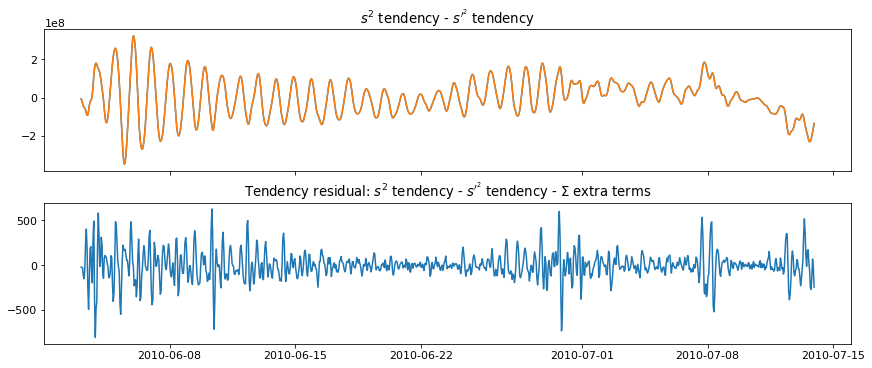

In [3]:
fig, ax = plt.subplots(2,1, figsize = (12,5), constrained_layout = True)

ax[0].plot(time, ds2dt-dsprime2dt)
ax[0].plot(time, dsbar2dt+dsbarsprimedt)
ax[0].set_xticklabels([])
ax[0].set_title(r'$s^2$ tendency - $s^{\prime^2}$ tendency')

ax[1].plot(time, ds2dt-dsprime2dt-(dsbar2dt+dsbarsprimedt))
ax[1].set_title('Tendency residual: $s^2$ tendency - $s^{\prime^2}$ tendency - $\Sigma$ extra terms')

Text(0.5, 1.0, 'Advection residual: $s^2$ advection - $s^{\\prime^2}$ advection - $\\Sigma$ extra terms')

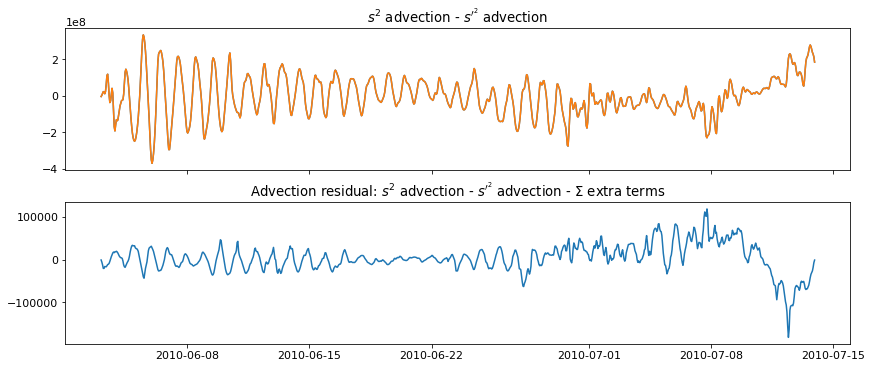

In [4]:
fig, ax = plt.subplots(2,1, figsize = (12,5), constrained_layout = True)

ax[0].plot(time, s2_advection-sprime2_advection)
ax[0].plot(time, sbarsprime_advection+sbar2_advection)
ax[0].set_xticklabels([])
ax[0].set_title(r'$s^2$ advection - $s^{\prime^2}$ advection')

ax[1].plot(time, s2_advection-sprime2_advection-(sbarsprime_advection+sbar2_advection))
ax[1].set_title('Advection residual: $s^2$ advection - $s^{\prime^2}$ advection - $\Sigma$ extra terms')

# As expected, the advection terms have a sizeable residual, but it is several orders of magnitude smaller than the actual magnitude of the terms. 

Text(0.5, 1.0, 'Surface residual: $s^2$ surface - $s^{\\prime^2}$ surface - $\\Sigma$ extra terms')

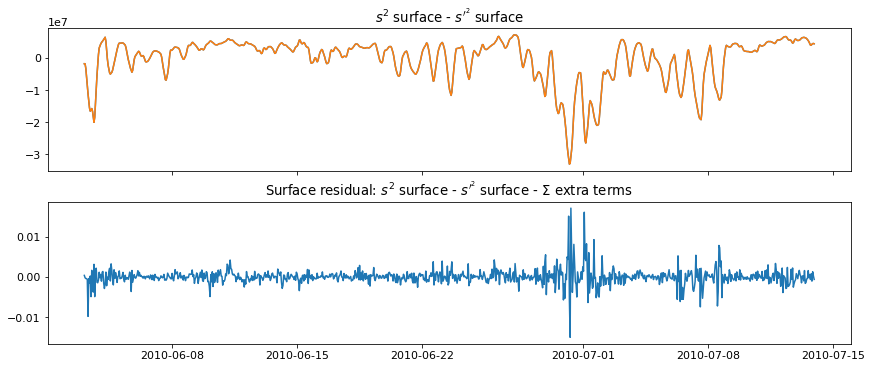

In [5]:
fig, ax = plt.subplots(2,1, figsize = (12,5), constrained_layout = True)

ax[0].plot(time, s2_surface-sprime2_surface)
ax[0].plot(time, surface_extra)
ax[0].set_xticklabels([])
ax[0].set_title(r'$s^2$ surface - $s^{\prime^2}$ surface')

ax[1].plot(time, s2_surface-sprime2_surface-(surface_extra))
ax[1].set_title('Surface residual: $s^2$ surface - $s^{\prime^2}$ surface - $\Sigma$ extra terms')

# Plot the tracer budgets 

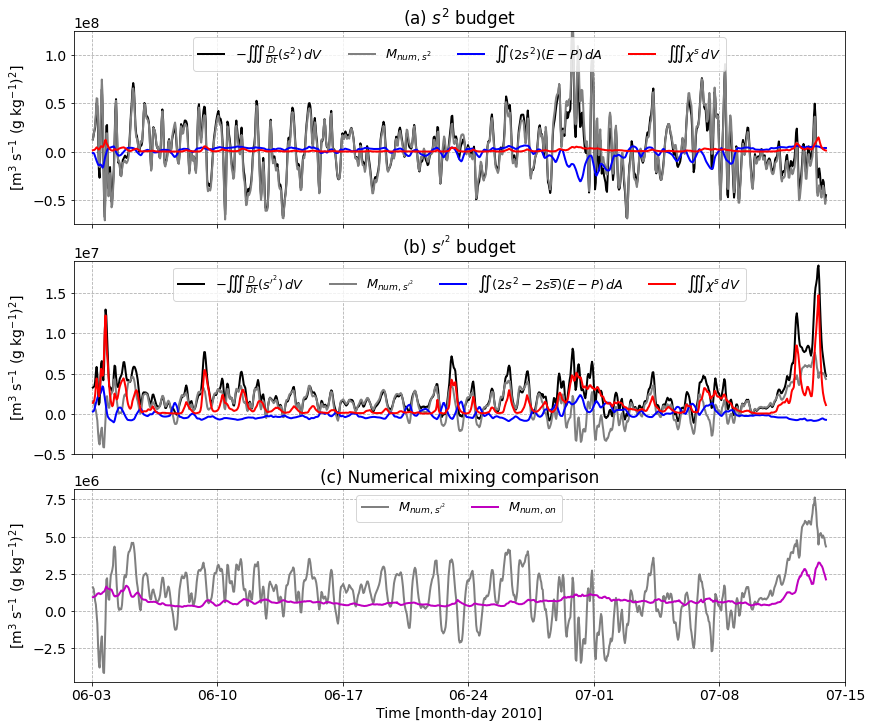

In [6]:
s2_material = ds2dt+s2_advection
sprime2_material = dsprime2dt+sprime2_advection

plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(3,1, figsize = (12,10), constrained_layout = True, sharey = False)

ax[0].plot(time, -s2_material, lw = 2, color = 'k',label = r'$-\iiint \frac{D}{Dt}(s^2) \, dV$')
ax[0].plot(time, mnum_ss, lw = 2, color = 'grey',label = r'$M_{num, s^2}$')
ax[0].plot(time, s2_surface, lw = 2, color = 'b',label = r'$\iint (2s^2)(E-P) \, dA$')
ax[0].plot(time, chi_online, lw = 2, color = 'r',label = r'$\iiint \chi^s \, dV$')

ax[0].set_ylim(-.75e8,1.25e8)
ax[0].set_title(r'(a) $s^2$ budget')
ax[0].legend(loc = 'upper center', ncol = 4, fontsize = 13)
ax[0].set_xticklabels([])

ax[1].plot(time, -sprime2_material, color = 'k', lw = 2, label = r'$-\iiint \frac{D}{Dt}(s^{\prime^2}) \, dV$')
ax[1].plot(time, mnum_sprime2, color = 'grey', lw = 2, label = r'$M_{num, s^{\prime^2}}$')
ax[1].plot(time, sprime2_surface, color = 'b', lw = 2, label = r'$\iint (2s^2-2s \overline{s})(E-P) \, dA$')
ax[1].plot(time, chi_online, color = 'r', lw = 2, label = r'$\iiint \chi^s \, dV$')
ax[1].set_ylim(-.5e7,1.9e7)
ax[1].set_title(r'(b) $s^{\prime^2}$ budget')
ax[1].legend(loc = 'upper center', ncol = 4, fontsize = 13)
ax[1].set_xticklabels([])

ax[2].plot(time, mnum_sprime2, lw = 2, color = 'grey', label = r'$M_{num, s^{\prime^2}}$')
ax[2].plot(time, mnum_online, lw = 2, color = 'm', label = '$M_{num, on}$')
ax[2].set_title('(c) Numerical mixing comparison')
ax[2].legend(loc = 'upper center', ncol = 2, fontsize = 13)
# bbox_to_anchor=(1.0, 1.02)
#Format the date-ticks
myFmt = mdates.DateFormatter("%m-%d")
dates = ['2010-06-03', '2010-06-10', '2010-06-17', '2010-06-24',
         '2010-07-01', '2010-07-08', '2010-07-15']
#Convert date strings (e.g. 2014-10-18) to datetime
dates = [datetime.strptime(d, "%Y-%m-%d") for d in dates]
for i in range(3):
    ax[i].xaxis.set_major_formatter(myFmt)
    ax[i].set_xlim(datetime(2010,6,2), datetime(2010,7,15))
    ax[i].set_ylabel(r'[m$^3$ s$^{-1}$ (g kg$^{-1}$)$^2$]')
    ax[i].set_xticks(ticks = dates)
    ax[i].grid(linestyle = '--')
ax[i].set_xlabel('Time [month-day 2010]')
for i in range(2):
    ax[i].set_xticklabels([])
    
# plt.savefig('/d2/home/dylan/JAMES/figures/budget_comparison_material.jpg', dpi = 300, bbox_inches='tight')

# Plot the extra terms 

Text(0, 0.5, '[m$^3$ s$^{-1}$]')

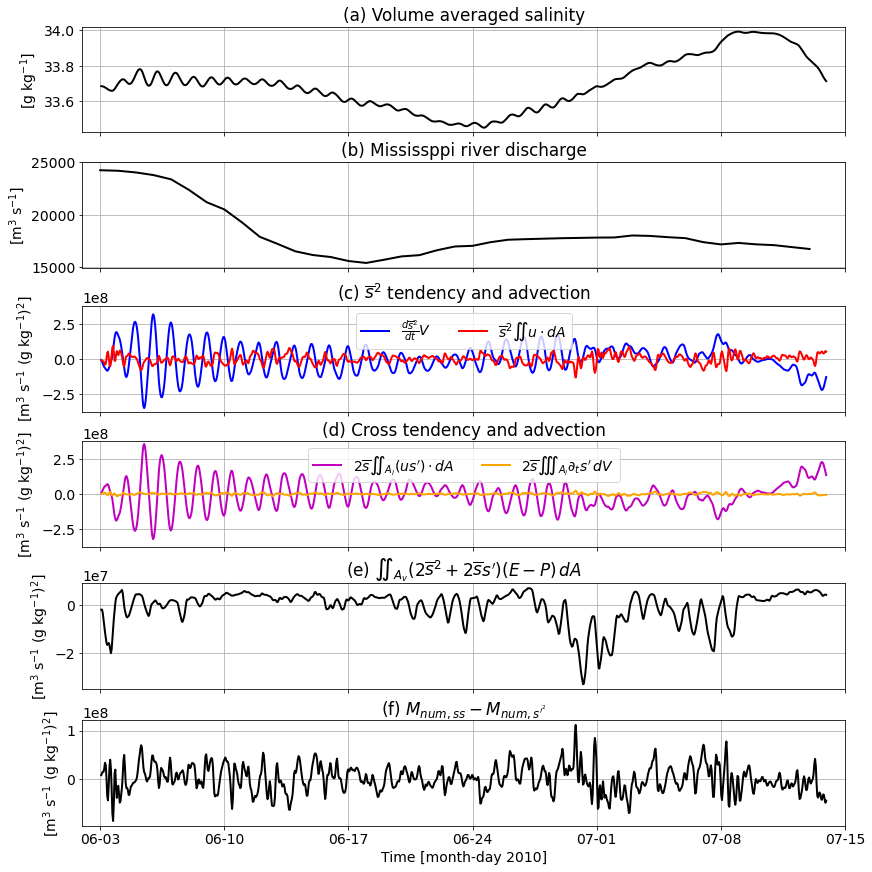

In [8]:
discharge =  xr.open_dataset('/d1/shared/TXLA_ROMS/inputs/rivers/txla2_river_2010_AR_newT_SWpass_weekly.nc').river_transport
river = np.abs(discharge).sum(axis = 1).sel(river_time = slice('2010-06-03', '2010-07-13'))*(2./3.)

fig, ax = plt.subplots(6,1, figsize = (12,2.4*5), constrained_layout = True, sharey = False)

ax[0].plot(time, sbar_parent[:983], color = 'k', lw = 2)
ax[0].set_title('(a) Volume averaged salinity')

ax[1].plot(river.river_time, river, color = 'k', lw = 2)
ax[1].set_title('(b) Mississppi river discharge')
ax[1].set_yticks([15000, 20000, 25000])

ax[2].plot(time, dsbar2dt, lw = 2, color = 'b', label = r'$\frac{d\overline{s}^2}{dt}V$')
ax[2].plot(time, sbar2_advection, lw = 2, color = 'r', label = r'$\overline{s}^2 \iint u \cdot dA$')
ax[2].legend(loc = 'upper center', ncol = 2)
ax[2].set_title(r'(c) $\overline{s}^2$ tendency and advection')
ax[2].set_ylim(-3.75e8,3.75e8)

ax[3].plot(time, sbarsprime_advection, color = 'm', lw = 2, label = r'$2\overline{s} \iint_{A_l} (us^{\prime}) \cdot dA$')
ax[3].plot(time, dsbarsprimedt, color = 'orange', lw = 2, label = r'$2\overline{s}\iiint_{A_l} \partial_t s^\prime \, dV$')
ax[3].legend(loc = 'upper center', ncol = 2)
ax[3].set_title(r'(d) Cross tendency and advection')
ax[3].set_ylim(-3.75e8,3.75e8)

ax[4].plot(time, surface_extra, lw = 2, color = 'k')
ax[4].set_title(r'(e) $\iint_{A_v} (2 \overline{s}^2+2\overline{s}s^\prime)(E-P) \, dA$')

ax[5].plot(time, mnum_diff, lw = 2, color = 'k')
ax[5].set_title(r'(f) $M_{num, ss} - M_{num, s^{\prime^2}}$')

for i in range(6):
    ax[i].xaxis.set_major_formatter(myFmt)
    ax[i].set_xlim(datetime(2010,6,2), datetime(2010,7,15))
    ax[i].set_ylabel(r'[m$^3$ s$^{-1}$ (g kg$^{-1}$)$^2$]')
    ax[i].set_xticks(ticks = dates)
    ax[i].grid()
    
for i in range(5):
    ax[i].set_xticklabels([])
ax[i+1].set_xlabel('Time [month-day 2010]')

ax[0].set_ylabel('[g kg$^{-1}$]')
ax[1].set_ylabel('[m$^3$ s$^{-1}$]')
# plt.savefig('/d2/home/dylan/JAMES/figures/extra_terms.jpg', dpi = 300, bbox_inches='tight')

# Next, plot different ratios of mixing between the parent and child models 

In [9]:
timedrop = [np.datetime64('2010-06-18T18:30:00.000000000'), 
            np.datetime64('2010-06-19T18:30:00.000000000'), 
            np.datetime64('2010-07-09T18:30:00.000000000')]

chi_online = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/mixing/chi_online_2010_*.nc').sel(ocean_time = slice('2010-06-03', '2010-07-13'))
chi_online = chi_online.chi_online.where((chi_online.ocean_time!= timedrop[0])
                                             & (chi_online.ocean_time!= timedrop[1])
                                             & (chi_online.ocean_time!= timedrop[2]),
                                             drop=True)

mnum_online = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/mixing/mnum_online_2010_*.nc').sel(ocean_time = slice('2010-06-03', '2010-07-13'))
mnum_online = mnum_online.mnum_online.where((mnum_online.ocean_time!= timedrop[0])
                                             & (mnum_online.ocean_time!= timedrop[1])
                                             & (mnum_online.ocean_time!= timedrop[2]),
                                             drop=True)

chi_online_child = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/mixing/chi_online_nested_2010_*.nc').sel(ocean_time = slice('2010-06-03', '2010-07-13'))
chi_online_child = chi_online_child.chi_online.where((chi_online_child.ocean_time!= timedrop[0])
                                             & (chi_online_child.ocean_time!= timedrop[1])
                                             & (chi_online_child.ocean_time!= timedrop[2]),
                                             drop=True)
mnum_online_child = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/mixing/mnum_online_nested_2010_*.nc').sel(ocean_time = slice('2010-06-03', '2010-07-13'))
mnum_online_child = mnum_online_child.mnum_online.where((mnum_online_child.ocean_time!= timedrop[0])
                                             & (mnum_online_child.ocean_time!= timedrop[1])
                                             & (mnum_online_child.ocean_time!= timedrop[2]),
                                             drop=True)

#Second step - select only parent times where child output is available
chi_online = chi_online.where(chi_online_child.ocean_time==chi_online.ocean_time)
mnum_online = mnum_online.where(mnum_online_child.ocean_time==mnum_online.ocean_time)

mtotal_parent = chi_online+mnum_online
mtotal_child = chi_online_child+mnum_online_child


print(len(mnum_online_child.ocean_time))
print(len(mnum_online.ocean_time))
print(len(chi_online_child.ocean_time))
print(len(chi_online.ocean_time))

957
957
957
957


In [10]:
r1 = chi_online_child/chi_online
r2 = mnum_online_child/mnum_online
r3 = mtotal_child/mtotal_parent
r4 = mnum_online/chi_online
r5 = chi_online_child.mean().values/chi_online.mean().values
r6 = mnum_online_child.mean().values/mnum_online.mean().values
r7 = mtotal_child.mean().values/mtotal_parent.mean().values
r8 = mnum_online.mean().values/chi_online.mean().values
print(r1.mean().values)
print(r2.mean().values)
print(r3.mean().values)
print(r4.mean().values)
print(r5)
print(r6)
print(r7)
print(r8)

1.4953578066497686
0.6617542972042245
1.0413311463413846
1.7830587046830508
1.294261577403124
0.624286579114933
1.0517632921128046
0.5672783520526581


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

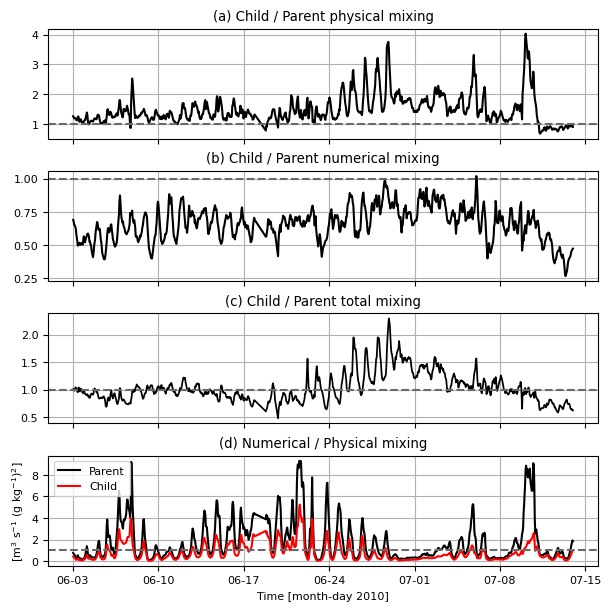

In [13]:
plt.rcParams.update({'font.size': 8})

fig, ax = plt.subplots(4, dpi = 100, figsize = (6,6), constrained_layout = True)

ax[0].plot(r1.ocean_time, r1, lw = 1.5, c = 'k')
ax[0].set_title('(a) Child / Parent physical mixing')
ax[0].set_ylabel('')

ax[1].plot(r1.ocean_time, r2, lw = 1.5, c = 'k')
ax[1].set_title('(b) Child / Parent numerical mixing')
ax[1].set_ylabel('')

ax[2].plot(r1.ocean_time, r3, lw = 1.25, c = 'k')
ax[2].set_title('(c) Child / Parent total mixing')

ax[3].plot(r1.ocean_time, r4, lw = 1.5, c = 'k', label = 'Parent')
ax[3].plot(r1.ocean_time, mnum_online_child/chi_online_child, lw = 1.5, c = 'r', label = 'Child')
ax[3].set_yticks([0,2,4,6,8])
ax[3].set_title('(d) Numerical / Physical mixing')
ax[3].set_ylabel('')
ax[3].legend()

for i in range(4):
    ax[i].xaxis.set_major_formatter(myFmt)
    ax[i].set_xticks(ticks = dates)
    
for i in range(3):
    ax[i].set_xticklabels([])
    ax[i].set_xlabel('')
    ax[i].grid()
    ax[i].set_ylabel('')
ax[i+1].grid()
ax[i+1].set_xlabel('')
ax[i+1].set_xlabel('Time [month-day 2010]')

for i in range(4):
    ax[i].axhline(y = 10**0, ls = '--', c = 'dimgrey')
ax[i].set_ylabel(r'[m$^3$ s$^{-1}$ (g kg$^{-1}$)$^2$]')
plt.setp(ax[3].xaxis.get_majorticklabels(), rotation=0)

# plt.savefig('/d2/home/dylan/JAMES/figures/mixing_comparison_time_series.jpg', dpi = 300, bbox_inches='tight')